# Human in the loop (HIL)
- Agent 사용 Case

https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

from langchain_community.embeddings import BedrockEmbeddings
embedding_model_id = "amazon.titan-embed-text-v2:0"
bedrock_embedding = BedrockEmbeddings(
    client=boto3_bedrock,
    region_name = bedrock_region,
    model_id = embedding_model_id
) 

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

In [6]:
import getpass
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Self-RAG"

In [8]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="이미지를 분석하기 위한 서비스에 대해 설명해줘."
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. 

주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 예를 들어 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 얼굴을 감지하고 나이, 성별 등의 속성을 분석합니다.

이미지 분석 서비스는 다양한 산업에서 활용되고 있습니다. 예를 들어 소매업에서는 제품 이미지 분류, 보안 분야에서는 CCTV 영상 분석, 의료 분야에서는 의료 영상 판독 등에 사용됩니다. 구글, 아마존, 마이크로소프트 등 주요 클라우드 업체들이 이미지 분석 API를 제공하고 있습니다.

'안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. \n\n주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 예를 들어 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 얼굴을 감지하고 나이, 성별 등의 속성을 분석합니다.\n\n이미지 분석 서비스는 다양한 산업에서 활용되고 있습니다. 예를 들어 소매업에서는 제품 이미지 분류, 보안 분야에서는 CCTV 영상 분석, 의료 분야에서는 의료 영상 판독 등에 사용됩니다. 구글, 아마존, 마이크로소프트 등 주요 클라우드 업체들이 이미지 분석 API를 제공하고 있습니다.'

## Simple Usage

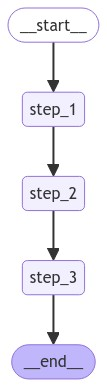

In [9]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

class State(TypedDict):
    input: str

def step_1(state):
    print("---Step 1---")
    pass

def step_2(state):
    print("---Step 2---")
    pass

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---


In [11]:
print("Current state!")
print(graph.get_state(thread).values)

graph.update_state(thread, {"input": "hello universe!"})

print("---\n---\nUpdated state!")
print(graph.get_state(thread).values)

Current state!
{'input': 'hello world'}
---
---
Updated state!
{'input': 'hello universe!'}


In [12]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

---Step 2---
---Step 3---


## Agent

In [13]:
# Set up the tool
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]

tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = chat.bind_tools(tools)

In [14]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]

    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)

    return {"messages": [response]}

flow = StateGraph(MessagesState)

In [15]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

workflow.add_edge("action", "agent")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

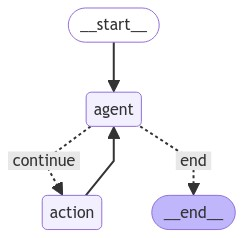

In [16]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Interacting with the Agent

In [17]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now
================================== Ai Message ==================================
Tool Calls:
  search (toolu_bdrk_011c8xQ3kzyBZWsjqPiwSodT)
 Call ID: toolu_bdrk_011c8xQ3kzyBZWsjqPiwSodT
  Args:
    query: san francisco weather


### Edit

In [18]:
current_state = app.get_state(thread)

last_message = current_state.values["messages"][-1]

last_message.tool_calls[0]["args"] = {"query": "current weather in SF"}

app.update_state(thread, {"messages": last_message})

{'configurable': {'thread_id': '3',
  'thread_ts': '1ef50ac4-6bcf-673c-8002-2eeab359f008'}}

In [19]:
current_state = app.get_state(thread)
current_state

StateSnapshot(values={'messages': [HumanMessage(content='search for the weather in sf now', id='8c6ccba8-06c2-455c-b4f7-5bc71dbb1339'), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 224, 'completion_tokens': 72, 'total_tokens': 296}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 224, 'completion_tokens': 72, 'total_tokens': 296}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-096f084c-1e5b-4ee2-b431-82967132ba34-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in SF'}, 'id': 'toolu_bdrk_011c8xQ3kzyBZWsjqPiwSodT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 72, 'total_tokens': 296})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef50ac4-6bcf-673c-8002-2eeab359f008'}}, metadata={'source': 'update', 'step': 2, 'writes': {'agent': {'messages': AIMessage(conte

In [20]:
last_message = current_state.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 224, 'completion_tokens': 72, 'total_tokens': 296}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 224, 'completion_tokens': 72, 'total_tokens': 296}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-096f084c-1e5b-4ee2-b431-82967132ba34-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in SF'}, 'id': 'toolu_bdrk_011c8xQ3kzyBZWsjqPiwSodT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 72, 'total_tokens': 296})

In [21]:
last_message.tool_calls[0]["args"]

{'query': 'current weather in SF'}

In [22]:
last_message.tool_calls[0]["args"] = {"query": "current weather in SF"}

### Resume

In [23]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."]
================================== Ai Message ==================================
Tool Calls:
  search (toolu_bdrk_01KBSM5MJ6jmxosNMiZsv2F7)
 Call ID: toolu_bdrk_01KBSM5MJ6jmxosNMiZsv2F7
  Args:
    query: san francisco weather forecast


## Tavily Search

In [24]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [25]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [26]:
!pip install -U tavily-python --quiet

In [27]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(k=5)
search.invoke("강남 맛집은?")

[{'url': 'https://www.siksinhot.com/toplists/best/101767_gangnam',
  'content': '점심 시간에 방문하기 좋은 강남역 맛집. 매일 직송하는 좋은 한우 등심을 맛볼 수 있는 곳으로 평양냉면, 설화등심 꽃등심 전문점으로 벽제갈비에서 직영하고 있습니다. 싱싱한 육회 및 전골요리와 한우특양탕도 인기입니다. 그릇. 강남역주변에서 직장인들이 ...'},
 {'url': 'https://www.tripadvisor.co.kr/RestaurantsNear-g294197-d9579483-Gangnam-Seoul.html',
  'content': '트립어드바이저에 있는 강남역 근처 음식점 정보: 서울, 대한민국의 강남역 근처 음식점에 관한 리뷰 177,034 개 및 생생한 사진 50,046 장을 확인하세요. ... Best 서울 강남역 근처 맛집.'},
 {'url': 'https://m.blog.naver.com/twin_couple/222717441660',
  'content': '존재하지 않는 이미지입니다. 그 전에 모아둔 강남역 맛집 내돈내산 모음 1탄 링크는 아래에... 강남역 맛집은 내 의지로 간다기보단, 회사사람들과의 점심약속은 다들 외식을 선호하다보니까 그렇게 많이... 1. 강남역 제철한식 맛집 : 들름집. 자신있게 강남역 ...'},
 {'url': 'https://breakingcube.com/강남역-맛집-최고의-5곳/',
  'content': '안가면 후회할 강남역 맛집 최고의 5곳을 소개합니다. (2022년 1월 업데이트) 목차 - Contents 숨기기. 강남역 맛집 첫 번째. 정돈 3호점 (구글 평점 4.5) 강남역 맛집 두 번째, 헤비스테이크 강남역점 (구글 평점 4.8) 강남역 맛집 세 번째, 땅코참숯구이 (구글 평점 4.5 ...'},
 {'url': 'https://m.blog.naver.com/ldi25/221201986790',
  'content': '그래도 다행인건리얼맛집

In [28]:
tools = [TavilySearchResults(max_results=1)]

In [29]:
tool_node = ToolNode(tools)
model = chat.bind_tools(tools)

In [30]:
import operator
from typing import Annotated, Sequence, TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [31]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [32]:
def call_model(state: AgentState):
    messages = state["messages"]
    response = model.invoke(messages)
    print('response: ', response)

    return {"messages": [response]}

In [33]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

workflow.add_edge("action", "agent")

app = workflow.compile()

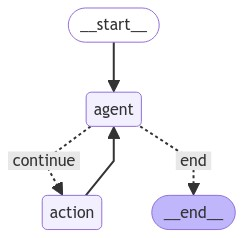

In [34]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [35]:
inputs = [HumanMessage(content="현재 서울의 날씨는?")]
for event in app.stream({"messages": inputs}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

현재 서울의 날씨는?
response:  content='' additional_kwargs={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-9b01e846-0b60-46eb-b2e5-4ecb14ae6f37-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'seoul weather'}, 'id': 'toolu_bdrk_01JZtYLPUGHozpu9LKsyMyry', 'type': 'tool_call'}] usage_metadata={'input_tokens': 275, 'output_tokens': 59, 'total_tokens': 334}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (toolu_bdrk_01JZtYLPUGHozpu9LKsyMyry)
 Call ID: toolu_bdrk_01JZtYLPUGHozpu9LKsyMyry
  Args:
    query: seoul weather
====

## Checkpoint

In [36]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

In [37]:
thread = {"configurable": {"thread_id": "5"}}
inputs = [HumanMessage(content="현재 서울의 날씨는?")]

for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

현재 서울의 날씨는?
response:  content='' additional_kwargs={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-12de4ab3-4397-40d8-9c03-2c9bf1612704-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'seoul weather'}, 'id': 'toolu_bdrk_017MExPG887HkKDR36uiM8HL', 'type': 'tool_call'}] usage_metadata={'input_tokens': 275, 'output_tokens': 59, 'total_tokens': 334}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (toolu_bdrk_017MExPG887HkKDR36uiM8HL)
 Call ID: toolu_bdrk_017MExPG887HkKDR36uiM8HL
  Args:
    query: seoul weather


In [38]:
current_state = app.get_state(thread)
current_state

StateSnapshot(values={'messages': [HumanMessage(content='현재 서울의 날씨는?'), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-12de4ab3-4397-40d8-9c03-2c9bf1612704-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'seoul weather'}, 'id': 'toolu_bdrk_017MExPG887HkKDR36uiM8HL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 275, 'output_tokens': 59, 'total_tokens': 334})]}, next=('action',), config={'configurable': {'thread_id': '5', 'thread_ts': '1ef50ac6-75eb-6370-8001-3ac62773af83'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'agent': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 

In [39]:
last_message = current_state.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 275, 'completion_tokens': 59, 'total_tokens': 334}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-12de4ab3-4397-40d8-9c03-2c9bf1612704-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'seoul weather'}, 'id': 'toolu_bdrk_017MExPG887HkKDR36uiM8HL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 275, 'output_tokens': 59, 'total_tokens': 334})

In [40]:
last_message.tool_calls[0]["args"]

{'query': 'seoul weather'}

In [41]:
last_message.tool_calls[0]["args"] = {'query': 'seoul weather'}

In [42]:
#app2.update_state(thread2, {"messages": last_message})

In [43]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Seoul', 'region': '', 'country': 'South Korea', 'lat': 37.57, 'lon': 127.0, 'tz_id': 'Asia/Seoul', 'localtime_epoch': 1722588587, 'localtime': '2024-08-02 17:49'}, 'current': {'last_updated_epoch': 1722588300, 'last_updated': '2024-08-02 17:45', 'temp_c': 31.2, 'temp_f': 88.2, 'is_day': 1, 'condition': {'text': 'Patchy rain nearby', 'icon': '//cdn.weatherapi.com/weather/64x64/day/176.png', 'code': 1063}, 'wind_mph': 6.7, 'wind_kph': 10.8, 'wind_degree': 250, 'wind_dir': 'WSW', 'pressure_mb': 1003.0, 'pressure_in': 29.63, 'precip_mm': 0.59, 'precip_in': 0.02, 'humidity': 67, 'cloud': 72, 'feelslike_c': 37.1, 'feelslike_f': 98.7, 'windchill_c': 31.2, 'windchill_f': 88.2, 'heatindex_c': 37.1, 'heatindex_f': 98.7, 'dewpoint_c': 24.2, 'dewpoint_f': 75.6, 'vis_km': 9.0, 'vis_miles': 5.0, 'uv': 7.0, 'gust_